In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray as xr

from convolve_load import load_rotation_matrices, load_elements, load_reciprocal, gather_nodes

device = "mps"

# 读入precompute的内容

* 这个任务只做一次。这些Tensors留在device，反复使用。

In [12]:
# ULVZ RTZ -> ULVZ XYZ
rotations = load_rotation_matrices().to(device)

# Load element
solid_elements, solid_connectivity = load_elements("solid", device=device)
fluid_elements, fluid_connectivity = load_elements("fluid", device=device)

# 实际ULVZ波场

* 下面的例子是从文件读取的。
* 反演时，它们是FNO的输入和输出，不来自文件（否则无法backprop）。

In [13]:
incident_solid = np.load("../wave_extrapolation/outputs/incident_ml_ready_solid.npz")["arr_0"]
incident_fluid = np.load("../wave_extrapolation/outputs/incident_ml_ready_fluid.npz")["arr_0"]
outgoing_solid = np.load("../wave_extrapolation/outputs/outgoing_ml_ready_solid.npz")["arr_0"]
outgoing_fluid = np.load("../wave_extrapolation/outputs/outgoing_ml_ready_fluid.npz")["arr_0"]

# 它们的差值，是做wave extrapolate的源
ulvz_u_solid = outgoing_solid - incident_solid
ulvz_u_fluid = outgoing_fluid - incident_fluid
ulvz_u_solid = np.transpose(ulvz_u_solid, (0, 1, 3, 4, 2))  # Depth放到最后
ulvz_u_fluid = np.transpose(ulvz_u_fluid, (0, 1, 3, 4, 2))
ulvz_u_solid = torch.from_numpy(ulvz_u_solid).float().to(device)
ulvz_u_fluid = torch.from_numpy(ulvz_u_fluid).float().to(device)

# 旋转到 XYZ
ulvz_u_solid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, ulvz_u_solid)
ulvz_u_fluid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, ulvz_u_fluid)

---

# 以上部分是所有站台公用的。以下是各个站台各自的convolve

---

# 读取站台的Green函数

In [14]:
# load reciprocal
station_name = "US.ERP"
recip_u_solid = load_reciprocal(ulvz_u_solid, station_name, "solid")
recip_u_fluid = load_reciprocal(ulvz_u_fluid, station_name, "fluid")

# 旋转到XYZ
recip_u_solid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, recip_u_solid)
recip_u_fluid = torch.einsum("tpij, Tjtpd -> Titpd", rotations, recip_u_fluid)

In [15]:
print(ulvz_u_solid.shape)
print(ulvz_u_fluid.shape)
print(recip_u_solid.shape)
print(recip_u_fluid.shape)

torch.Size([250, 3, 26, 60, 16])
torch.Size([250, 3, 26, 60, 6])
torch.Size([2003, 3, 26, 60, 16])
torch.Size([2003, 3, 26, 60, 6])


# 最终Convolve

In [16]:
# 搜集位移
ulvz_u_solid_elem = gather_nodes(ulvz_u_solid, solid_connectivity)
ulvz_u_fluid_elem = gather_nodes(ulvz_u_fluid, fluid_connectivity)
recip_u_solid_elem = gather_nodes(recip_u_solid, solid_connectivity)
recip_u_fluid_elem = gather_nodes(recip_u_fluid, fluid_connectivity)

# Convolve 并求和
result = torch.zeros(len(ulvz_u_solid) + len(recip_u_solid) - 1).float().to(device)
for elem, u_ulvz, u_recip in zip(solid_elements, ulvz_u_solid_elem, recip_u_solid_elem):
    result += elem.compute_convolve(u_ulvz, u_recip)
for elem, u_ulvz, u_recip in zip(fluid_elements, ulvz_u_fluid_elem, recip_u_fluid_elem):
    result += elem.compute_convolve(u_ulvz, u_recip)
result /= 1e20  # reciprocal 的放大系数
result = result.cpu().numpy()

# 对比结果

In [17]:
index = 348  # US.ERP
ds_1d = xr.load_dataset("../simulations/outputs/test/04_solve_prem/output/stations/ARRAY/axisem3d_synthetics.nc.rank0")
wave_1d = ds_1d["data"][:, 1, index]
print(wave_1d.shape)

ds_3d = xr.load_dataset("../simulations/outputs/test/12_solve_3d/output/stations/ARRAY/axisem3d_synthetics.nc.rank0")
wave_3d = ds_3d["data"][:, 1, index]
print(wave_3d.shape)

(2052,)
(1451,)


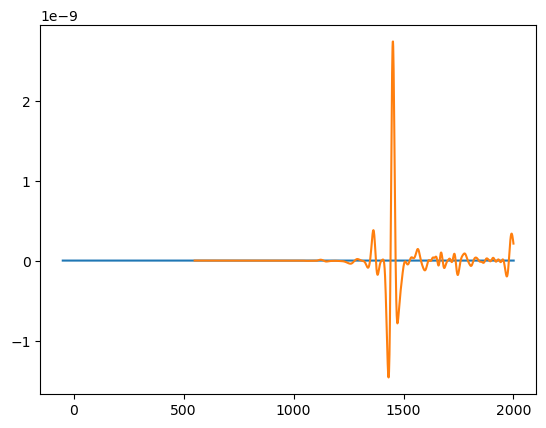

In [18]:
plt.plot(ds_1d["time_points"], wave_1d)
plt.plot(ds_3d["time_points"], wave_3d)

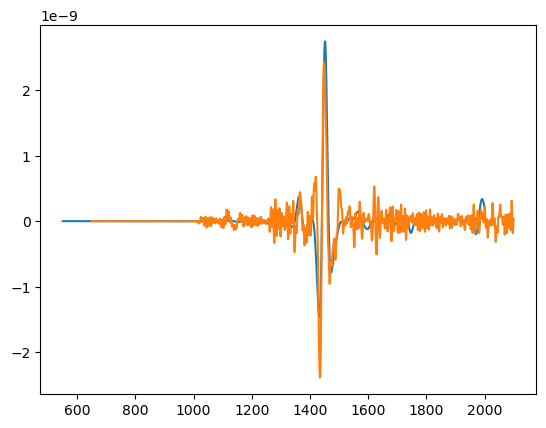

In [19]:
plt.plot(ds_3d["time_points"], wave_3d)
plt.plot(ds_3d["time_points"] + 100, result[:len(ds_3d["time_points"])] * 100)

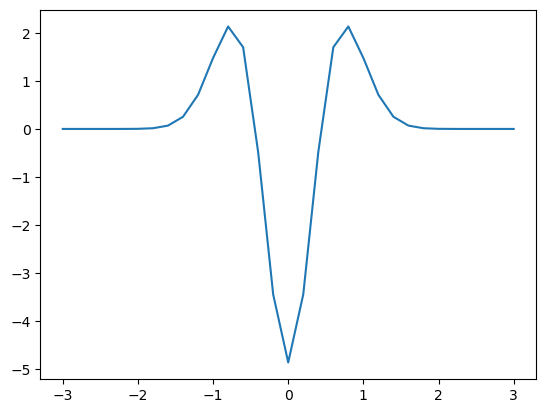

In [20]:
def recip_stf(t):
    return 4.86876 * (5.30077 * t ** 2 - 1) * np.exp(-2.65038 * t ** 2)

t = np.arange(-3., 3.01, 0.2)
stf = recip_stf(t)
plt.plot(t, stf)

In [21]:
from obspy.signal.filter import bandpass

# 假设 result 是一个 1D NumPy 数组
# 设置采样率（Hz）和滤波频率范围
sampling_rate = 5.0  # 每秒采样点数
freqmin = 1 / 500        # 最低频率 (Hz)
freqmax = 1 / 20        # 最高频率 (Hz)

# 应用带通滤波
filtered_result = bandpass(result, freqmin, freqmax, df=sampling_rate, corners=4, zerophase=True)
filtered_wave_3d = bandpass(wave_3d, freqmin, freqmax, df=sampling_rate, corners=4, zerophase=True)


In [22]:
wave_3d_convolved = np.convolve(filtered_wave_3d, stf, mode="full")

# a: Na
# b: Nb
# conv(a, b): Na + Nb - 1

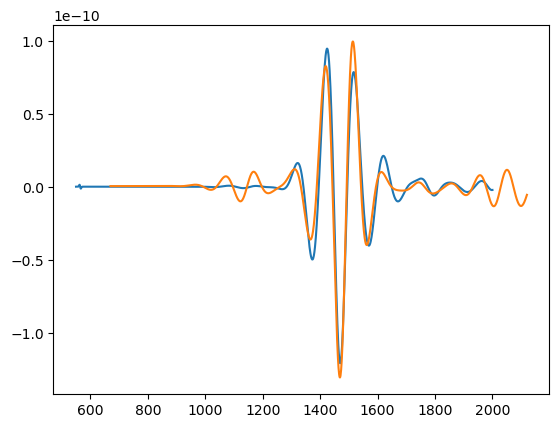

In [26]:
plt.plot(ds_3d["time_points"], wave_3d_convolved[:len(ds_3d["time_points"])])
plt.plot(ds_3d["time_points"] + 120, -filtered_result[:len(ds_3d["time_points"])] * 200)

In [24]:
# L = L_phys_ULVZ + L_obs_station